In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

D:\Anaconda\envs\DataScience\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 2.29G/2.29G [00:58<00:00, 42.0MB/s]

Extracting files...


Path to dataset files: C:\Users\VUHAI\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Augmentation cho training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = "Data"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
#val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

print(f"Training samples: {len(train_dataset)}, Valid samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.features = nn.Sequential(
            nn.Flatten(),  # Chuyển ảnh 2D thành vector
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 128, 512),  # input size = 128x128 (1 channel grayscale)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Binary classification with CrossEntropyLoss
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
        
summary(model, input_size=(1, 128, 128))

Training samples: 3662, Valid samples: 1570, Test samples: 624
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 16384]               0
            Linear-2                  [-1, 512]       8,389,120
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
Total params: 8,455,042
Trainable params: 8,455,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.14
Params size (MB): 32.25
Estimated Total Size (MB): 32.46
--------------------------------------

In [2]:
model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 10
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}:")
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.long().to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc.append(correct / total)
    train_loss.append(loss_sum / len(train_loader))
    print(f"Train acc: {correct / total}, Train loss: {loss_sum / len(train_loader)}")
    # Validation
    model.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.long().to(device)
            out = model(x)
            val_loss_sum += criterion(out, y).item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc.append(val_correct / val_total)
    val_loss.append(val_loss_sum / len(val_loader))
    scheduler.step(val_loss_sum / len(val_loader))
    print(f"Valid acc: {val_correct / val_total}, Valid loss: {val_loss_sum / len(val_loader)}")


D:\Anaconda\envs\DataScience\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:
Train acc: 0.7648825778263244, Train loss: 0.5687670640323473
Valid acc: 0.889171974522293, Valid loss: 0.2651218762993813
Epoch 2:
Train acc: 0.8891316220644456, Train loss: 0.26470450988930205
Valid acc: 0.9318471337579618, Valid loss: 0.16461769118905067
Epoch 3:
Train acc: 0.8989623156744948, Train loss: 0.24297434689234132
Valid acc: 0.9388535031847134, Valid loss: 0.17347361907362938
Epoch 4:
Train acc: 0.9194429273620972, Train loss: 0.20484434748473374
Valid acc: 0.9369426751592357, Valid loss: 0.16286155238747596
Epoch 5:
Train acc: 0.9309120699071546, Train loss: 0.17944390372089716
Valid acc: 0.9477707006369427, Valid loss: 0.14430523373186588
Epoch 6:
Train acc: 0.9183506280720918, Train loss: 0.2125457147217315
Valid acc: 0.956687898089172, Valid loss: 0.1410890518128872
Epoch 7:
Train acc: 0.9068814855270344, Train loss: 0.21032628054204194
Valid acc: 0.9579617834394905, Valid loss: 0.1618471398949623
Epoch 8:
Train acc: 0.8869470234844348, Train loss: 0.21648607

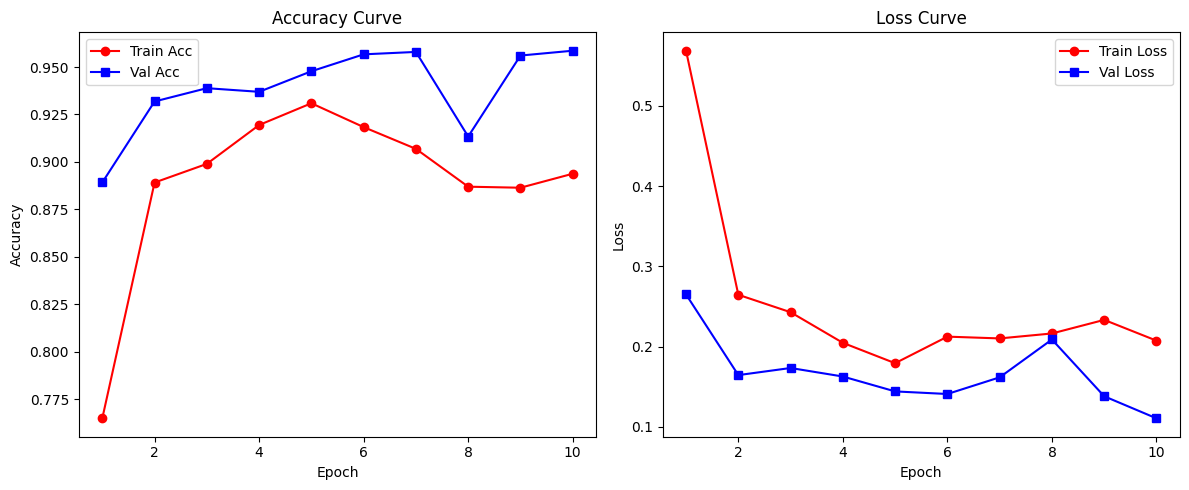

In [5]:
import matplotlib.pyplot as plt
train_acc = [
    0.7648825778263244,
    0.8891316220644456,
    0.8989623156744948,
    0.9194429273620972,
    0.9309120699071546,
    0.9183506280720918,
    0.9068814855270344,
    0.8869470234844348,
    0.886400873839432,
    0.8937738940469688
]

val_acc = [
    0.889171974522293,
    0.9318471337579618,
    0.9388535031847134,
    0.9369426751592357,
    0.9477707006369427,
    0.956687898089172,
    0.9579617834394905,
    0.913375796178344,
    0.9560509554140127,
    0.9585987261146497
]

train_loss = [
    0.5687670640323473,
    0.26470450988930205,
    0.24297434689234132,
    0.20484434748473374,
    0.17944390372089716,
    0.2125457147217315,
    0.21032628054204194,
    0.2164860707262288,
    0.23342635800009187,
    0.20755088750434958
]

val_loss = [
    0.2651218762993813,
    0.16461769118905067,
    0.17347361907362938,
    0.16286155238747596,
    0.14430523373186588,
    0.1410890518128872,
    0.1618471398949623,
    0.2089846883714199,
    0.13825388506054878,
    0.11075689814984799
]
epochs = list(range(1, len(train_acc) + 1))
# Combined plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy subplot
axes[0].plot(epochs, train_acc, 'r-o', label='Train Acc')
axes[0].plot(epochs, val_acc, 'b-s', label='Val Acc')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss subplot
axes[1].plot(epochs, train_loss, 'r-o', label='Train Loss')
axes[1].plot(epochs, val_loss, 'b-s', label='Val Loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig("train_val_metrics_MLP.png")  # Save the figure
plt.show()


In [4]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
loss_test = criterion(torch.tensor(out.cpu().numpy()), torch.tensor(y)).item()

print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, F1: {f1:.4f}, Loss: {loss_test:.4f}")
print(classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'], zero_division=0))

Test Accuracy: 0.7548, Precision: 0.7232, F1: 0.8339, Loss: 0.0092
              precision    recall  f1-score   support

      NORMAL       0.94      0.37      0.53       234
   PNEUMONIA       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.80      0.75      0.72       624



C:\Users\VUHAI\AppData\Local\Temp\ipykernel_4620\120999800.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_test = criterion(torch.tensor(out.cpu().numpy()), torch.tensor(y)).item()


In [5]:
import numpy as np
print("Unique predicted labels:", np.unique(all_preds))
print("Label counts:", pd.Series(all_preds).value_counts())

Unique predicted labels: [0 1]
Label counts: 1    531
0     93
Name: count, dtype: int64


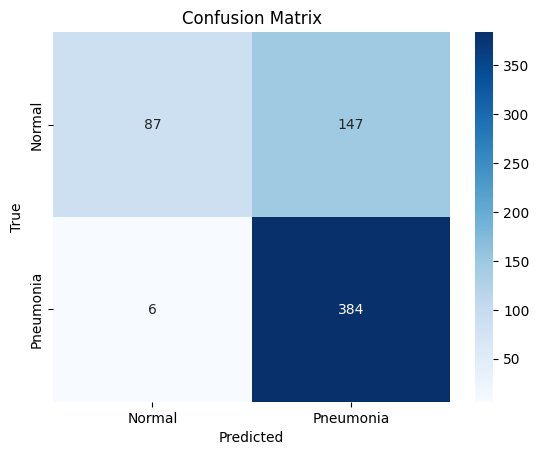

In [6]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
